# Figure 4, copy number variation spanning GCH1

In [1]:
%run ../../shared_setup.ipynb

The Cython magic has been move to the Cython package, hence 
`%load_ext cythonmagic` is deprecated; Please use `%load_ext Cython` instead.

Though, because I am nice, I'll still try to load it for you this time.


In [2]:
all_samples = []
for cross in CROSSES:
    all_samples += vcf.Reader(filename=COMBINED_VCF_FN_TEMPLATE.format(cross=cross)).samples
run2clone = dict((s.split('/')[2], s.split('/')[0]) for s in all_samples)
run2sample = dict((s.split('/')[2], s) for s in all_samples)
run2clone

{'ERR012788': 'HB3',
 'ERR012840': 'DD2',
 'ERR012892': 'QC23',
 'ERR012895': 'QC13',
 'ERR015446': '7C170',
 'ERR015447': 'GC03',
 'ERR015448': '7C183',
 'ERR015449': '1BB5',
 'ERR015450': 'TC05',
 'ERR015451': '7C20',
 'ERR015452': '7C126',
 'ERR015453': 'QC34',
 'ERR015454': '7C140',
 'ERR015455': '7C16',
 'ERR015456': 'GC06',
 'ERR015457': '7C111',
 'ERR015458': '7C408',
 'ERR015459': '7C421',
 'ERR019042': 'B4R3',
 'ERR019043': '7C424',
 'ERR019044': 'B1SD',
 'ERR019045': 'SC01',
 'ERR019046': '7C188',
 'ERR019047': '7C3',
 'ERR019048': '7C101',
 'ERR019049': '7C7',
 'ERR019050': 'QC01',
 'ERR019051': 'SC05',
 'ERR019052': 'TC08',
 'ERR019053': '3BD5',
 'ERR019054': 'HB3',
 'ERR019055': 'C06',
 'ERR019056': 'C07',
 'ERR019057': 'C09',
 'ERR019058': 'C14',
 'ERR019059': 'C04',
 'ERR019060': 'C10',
 'ERR019061': '3D7',
 'ERR019062': 'C13',
 'ERR019063': 'C12',
 'ERR019064': 'C01',
 'ERR019065': 'C05',
 'ERR019066': 'C02',
 'ERR019067': 'C02',
 'ERR019068': 'C02',
 'ERR019069': 'C15'

In [3]:
def plot_cnv_state(ax, run, chrom, start=0, stop=None, window_size=300, **kwargs):

    cnv = np.load(CNV_FN_TEMPLATE.format(run=run, window_size=window_size, chrom=chrom)).view(np.recarray)
    pos, _, Cn, H = cnv[:,0], cnv[:,1], cnv[:,2], cnv[:,3]
    
    if stop is None:
        stop = len(genome[chrom])

    start_idx, stop_idx = bisect_left(pos, start), bisect_right(pos, stop)
    pos, Cn, H = pos[start_idx:stop_idx], Cn[start_idx:stop_idx], H[start_idx:stop_idx]

    X = pos
    Y = Cn
    
    sns.despine(ax=ax, offset=5, bottom=True)
    ax.plot(X, Y, marker='o', linestyle=' ', mfc='none', mew=.5, mec=(0, 0, 0, .7), markersize=3)
    ax.plot(X, H, color='k', linestyle='-', linewidth=1)
    ax.set_xlim(start, stop)
    ax.set_xticks([])
    ax.set_ylim(0, 6)
    ax.set_yticks(range(6))
    ax.set_yticklabels(range(6), fontsize=8)
    ax.grid(axis='y', linestyle=':')
    

In [4]:
chrom, start, stop = 'Pf3D7_12_v3', 899000, 1148000

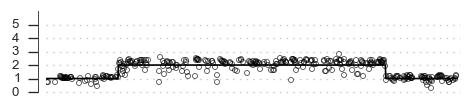

In [5]:
width = 4
height = 1
fig, ax = plt.subplots(figsize=(width, height))
plot_cnv_state(ax, 'ERR019054', chrom, start=start, stop=stop)
fig.tight_layout()

In [6]:
# def plot_coverage_ext(ax, run, f, chrom, start=0, stop=None, window_size=300, linewidth=1.5, **kwargs):
    
#     coverage = np.load(COVERAGE_FN_TEMPLATE.format(run=run, window_size=window_size, chrom=chrom)).view(np.recarray)

#     if stop is None:
#         stop = len(genome[chrom])

#     start_idx, stop_idx = bisect_left(coverage.pos, start), bisect_right(coverage.pos, stop)
#     coverage = coverage[start_idx:stop_idx]

#     X = coverage.pos
#     Y = f(coverage)
    
#     ax.set_xticks([])
#     ax.plot(X, Y, linewidth=linewidth, **kwargs)
#     ax.set_ylim(0, 20)
#     ax.set_xlim(start, stop)

    
# def plot_coverage_tandemdup(ax, run, chrom, start=0, stop=None, window_size=300, **kwargs):
#     f = lambda coverage: coverage.reads_faceaway * 100. / coverage.reads_all
#     plot_coverage_ext(ax, run, f, chrom, start=start, stop=stop, window_size=window_size, **kwargs)

    
# def plot_coverage_inversion(ax, run, chrom, start=0, stop=None, window_size=300, **kwargs):
#     f = lambda coverage: coverage.reads_mate_same_strand * 100. / coverage.reads_all
#     plot_coverage_ext(ax, run, f, chrom, start=start, stop=stop, window_size=window_size, **kwargs)


In [7]:
cov_cache_fn_template = '/data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/cache/{run}.{chrom}.{start}.{stop}.coverage_ext.npy'

def plot_coverage_ext(ax, run, f, chrom, start, stop, **kwargs):
    cov_fn = cov_cache_fn_template.format(run=run, chrom=chrom, start=start, stop=stop)
    if not os.path.exists(cov_fn):
        bam_fn = BAM_FN_TEMPLATE.format(run=run)
        bam = pysam.AlignmentFile(bam_fn)
        a = pysamstats.load_coverage_ext(bam, chrom=chrom, start=start, stop=stop, pad=True)
        np.save(cov_fn, a)
    else:
        a = np.load(cov_fn).view(np.recarray)
    x = a.pos
    y = f(a)
    ax.plot(x, y, **kwargs)
    ax.set_xlim(start, stop)
    
def plot_coverage_tandemdup(ax, run, chrom, start=0, stop=None, **kwargs):
    f = lambda coverage: coverage.reads_faceaway #* 100. / coverage.reads_all
    plot_coverage_ext(ax, run, f, chrom, start=start, stop=stop, **kwargs)

    
def plot_coverage_inversion(ax, run, chrom, start=0, stop=None, **kwargs):
    f = lambda coverage: coverage.reads_mate_same_strand #* 100. / coverage.reads_all
    plot_coverage_ext(ax, run, f, chrom, start=start, stop=stop, **kwargs)


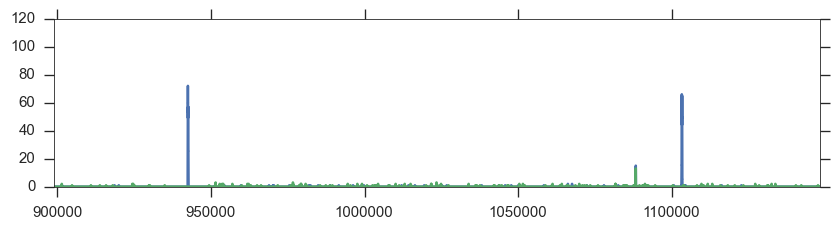

In [8]:
width = 7
height = 2
fig, ax = plt.subplots(figsize=(width, height))
plot_coverage_tandemdup(ax, 'ERR019054', chrom, start=start, stop=stop, lw=1.5)
plot_coverage_inversion(ax, 'ERR019054', chrom, start=start, stop=stop, lw=1.5)
fig.tight_layout()

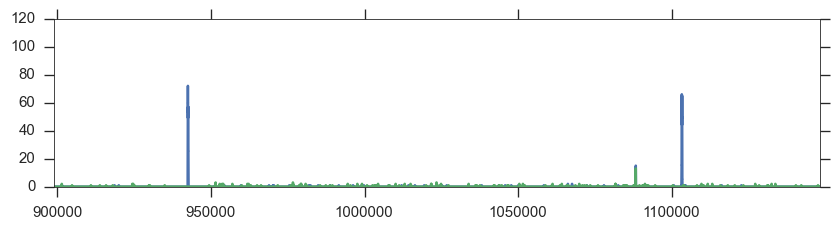

In [9]:
width = 7
height = 2
fig, ax = plt.subplots(figsize=(width, height))
plot_coverage_tandemdup(ax, 'ERR019054', chrom, start=start, stop=stop, lw=1.5)
plot_coverage_inversion(ax, 'ERR019054', chrom, start=start, stop=stop, lw=1.5)
fig.tight_layout()

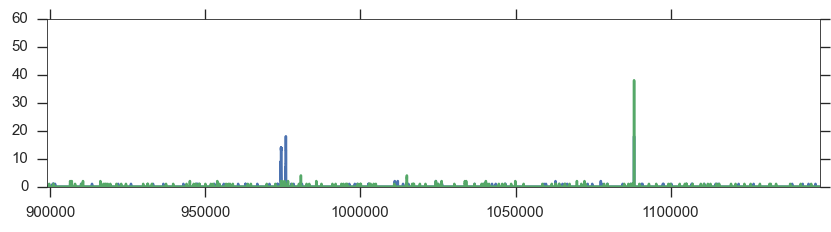

In [10]:
width = 7
height = 2
fig, ax = plt.subplots(figsize=(width, height))
plot_coverage_tandemdup(ax, 'ERR019061', chrom, start=start, stop=stop, lw=1.5)
plot_coverage_inversion(ax, 'ERR019061', chrom, start=start, stop=stop, lw=1.5)
fig.tight_layout()

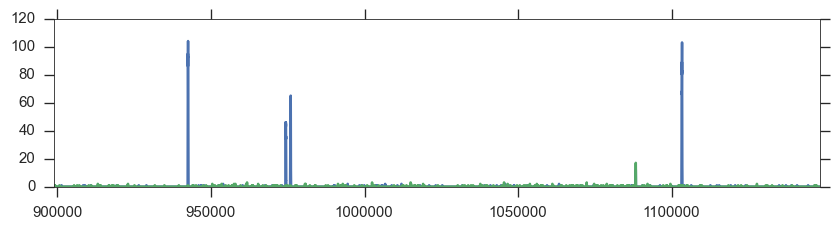

In [11]:
width = 7
height = 2
fig, ax = plt.subplots(figsize=(width, height))
plot_coverage_tandemdup(ax, 'ERR019055', chrom, start=start, stop=stop, lw=1.5)
plot_coverage_inversion(ax, 'ERR019055', chrom, start=start, stop=stop, lw=1.5)
fig.tight_layout()

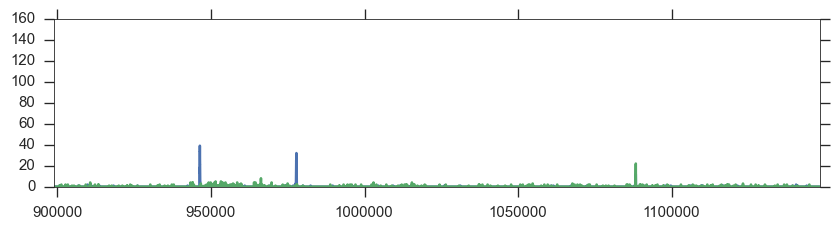

In [12]:
width = 7
height = 2
fig, ax = plt.subplots(figsize=(width, height))
plot_coverage_tandemdup(ax, 'ERR027099', chrom, start=start, stop=stop, lw=1.5)
plot_coverage_inversion(ax, 'ERR027099', chrom, start=start, stop=stop, lw=1.5)
fig.tight_layout()

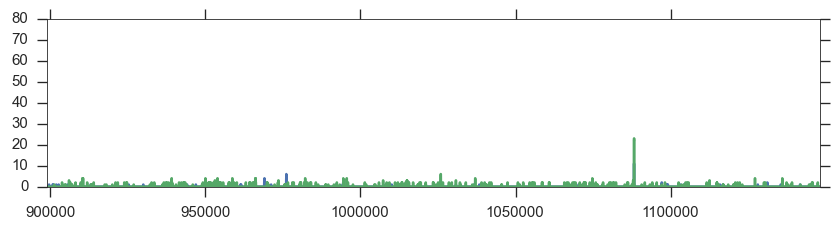

In [13]:
width = 7
height = 2
fig, ax = plt.subplots(figsize=(width, height))
plot_coverage_tandemdup(ax, 'ERR027100', chrom, start=start, stop=stop, lw=1.5)
plot_coverage_inversion(ax, 'ERR027100', chrom, start=start, stop=stop, lw=1.5)
fig.tight_layout()

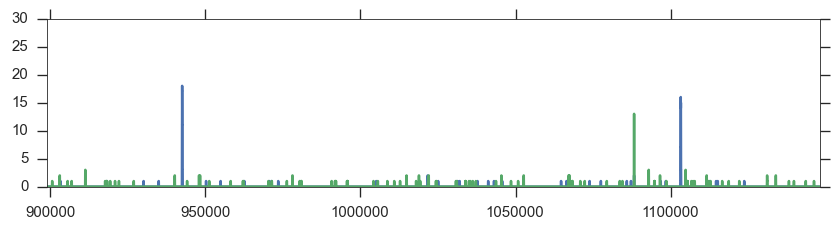

In [14]:
width = 7
height = 2
fig, ax = plt.subplots(figsize=(width, height))
plot_coverage_tandemdup(ax, 'ERR012788', chrom, start=start, stop=stop, lw=1.5)
plot_coverage_inversion(ax, 'ERR012788', chrom, start=start, stop=stop, lw=1.5)
fig.tight_layout()

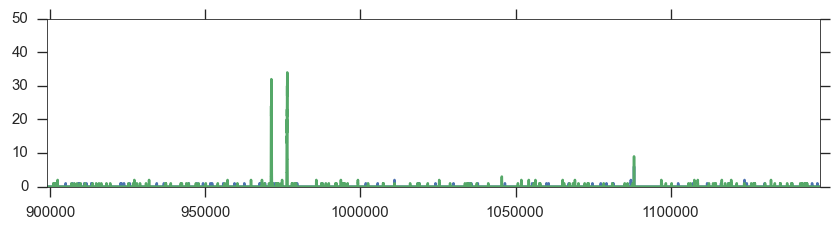

In [15]:
width = 7
height = 2
fig, ax = plt.subplots(figsize=(width, height))
plot_coverage_tandemdup(ax, 'ERR012840', chrom, start=start, stop=stop, lw=1.5)
plot_coverage_inversion(ax, 'ERR012840', chrom, start=start, stop=stop, lw=1.5)
fig.tight_layout()

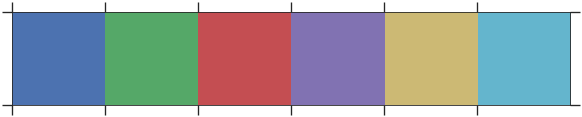

In [16]:
sns.palplot(sns.color_palette())

In [17]:
def plot_cnv_evidence(fig, run, chrom, start, stop, label_axes=False, extra_label=''):
    
    gs = GridSpec(2, 1, height_ratios=[1, .6])
    palette = sns.color_palette()
    
    ax = fig.add_subplot(gs[0])
    plot_cnv_state(ax, run, chrom, start=start, stop=stop)
    if label_axes:
        ax.text(0, 1, 'CN', fontsize=8, fontweight='bold', ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor='w', lw=0, alpha=1))
    ax.text(1, 1, '%s %s' % (run2clone[run], extra_label), 
            fontsize=8, fontweight='bold', 
            ha='right', va='top', 
            transform=ax.transAxes, 
            bbox=dict(facecolor='w', lw=0, alpha=1))
#     ax.set_ylabel('CN', fontsize=8, rotation=90, ha='right')
    
    ax = fig.add_subplot(gs[1])
    sns.despine(ax=ax, offset=5, bottom=True, left=False)
    plot_coverage_inversion(ax, run, chrom, start=start, stop=stop, color=palette[3], lw=1)
#     ax.set_ylabel(r'%DP', 
#                   rotation=90, ha='center', va='bottom', 
#                   color='k', fontweight='normal', fontsize=8)
#     ax.set_yticks([0, 10])
#     ax.set_yticklabels([0, 10], fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([0, 40])
    ax.set_yticklabels(['0', '40'], fontsize=8)
    ax.set_ylim(0, 40)
    if label_axes:
        ax.text(0, .9, r'FA $\leftarrow$$\rightarrow$', color=palette[1], transform=ax.transAxes, ha='left', va='top',
                fontsize=8, fontweight='bold')
        ax.text(0, .6, r'SS $\rightarrow$$\rightarrow$', color=palette[3], transform=ax.transAxes, ha='left',va='top',
                fontsize=8, fontweight='bold')

    ax = ax.twinx()
    sns.despine(ax=ax, offset=5, bottom=True, right=True, left=True)
    plot_coverage_tandemdup(ax, run, chrom, start=start, stop=stop, color=palette[1], lw=1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_ylim(0, 40)
#     ax.set_ylabel(r'%SS', 
#                   rotation=90, ha='center', va='top', 
#                   color=palette[3], fontweight='bold', fontsize=8)
    
    fig.tight_layout(h_pad=0)
    

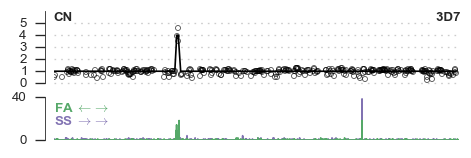

In [18]:
fig = plt.figure(figsize=(4, 1.4))
plot_cnv_evidence(fig, 'ERR019061', chrom, start, stop, label_axes=True)
fig.savefig('../../artwork/main/fig4A.jpg', dpi=900, jpeg_quality=100)

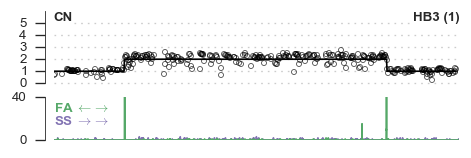

In [19]:
fig = plt.figure(figsize=(4, 1.4))
plot_cnv_evidence(fig, 'ERR019054', chrom, start, stop, extra_label='(1)', label_axes=True)
fig.savefig('../../artwork/main/fig4B.jpg', dpi=900, jpeg_quality=100)

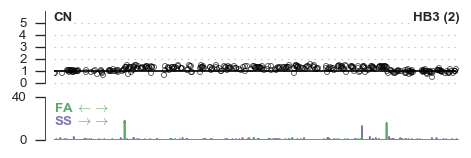

In [20]:
fig = plt.figure(figsize=(4, 1.4))
plot_cnv_evidence(fig, 'ERR012788', chrom, start, stop, extra_label='(2)', label_axes=True)
fig.savefig('../../artwork/main/fig4B2.jpg', dpi=900, jpeg_quality=100)

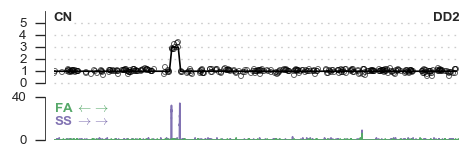

In [21]:
fig = plt.figure(figsize=(4, 1.4))
plot_cnv_evidence(fig, 'ERR012840', chrom, start, stop, label_axes=True)
fig.savefig('../../artwork/main/fig4C.jpg', dpi=900, jpeg_quality=100)

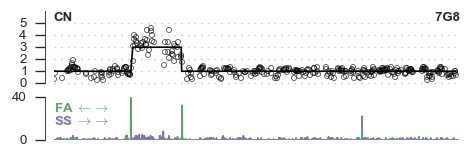

In [22]:
fig = plt.figure(figsize=(4, 1.4))
plot_cnv_evidence(fig, 'ERR027099', chrom, start, stop, label_axes=True)
fig.savefig('../../artwork/main/fig4D.jpg', dpi=900, jpeg_quality=100)

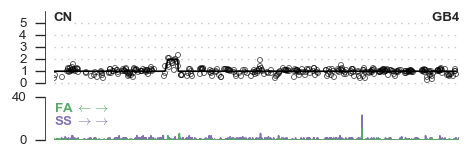

In [23]:
fig = plt.figure(figsize=(4, 1.4))
plot_cnv_evidence(fig, 'ERR027100', chrom, start, stop, label_axes=True)
fig.savefig('../../artwork/main/fig4E.jpg', dpi=900, jpeg_quality=100)

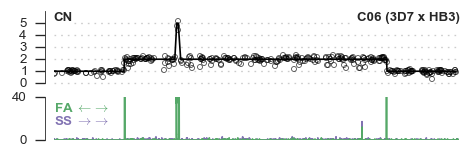

In [24]:
fig = plt.figure(figsize=(4, 1.4))
plot_cnv_evidence(fig, 'ERR019055', chrom, start, stop, extra_label='(3D7 x HB3)', label_axes=True)

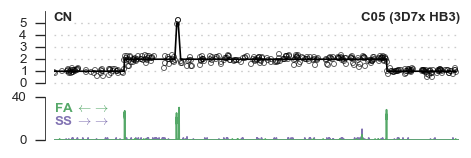

In [25]:
fig = plt.figure(figsize=(4, 1.4))
plot_cnv_evidence(fig, 'ERR019065', chrom, start, stop, extra_label='(3D7x HB3)', label_axes=True)

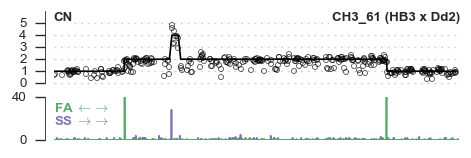

In [26]:
fig = plt.figure(figsize=(4, 1.4))
plot_cnv_evidence(fig, 'ERR175544', chrom, start, stop, extra_label='(HB3 x Dd2)', label_axes=True)

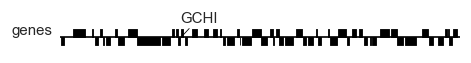

In [27]:
fig = plt.figure(figsize=(4, .5))
ax = fig.add_subplot(111)
annotate_genes = ['PF3D7_1224000']
gene_labels = {'PF3D7_1224000': 'GCHI'}
annotate_bbox = dict()
annotate_arrowprops = dict(arrowstyle='-',
                           connectionstyle='arc3',
                           shrinkA=0, shrinkB=0, linewidth=.5, edgecolor='k')
plot_genes(ax, chrom, start=start, stop=stop, annotate_genes=annotate_genes, gene_labels=gene_labels, annotate_xtext=0,
           annotate_ytext_fwd=9, annotate_bbox=annotate_bbox, annotate_arrowprops=annotate_arrowprops)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
# ax.text(.9, -.7, 'chromosome 12\nposition (bp)', transform=ax.transAxes)
ax.set_ylabel('genes', rotation=0, ha='right');
fig.tight_layout()
fig.savefig('../../artwork/main/fig4F.jpg', dpi=900, jpeg_quality=100)

## Plot progeny with recombination

In [28]:
8 * 2.54

20.32

In [29]:
(1.4*5 + 1) * 2.54

20.32

In [30]:
def _variant_filter(v, c, cd2):
    return (
        ~v.FILTER_NON_CORE
        & ~v.FILTER_NON_SEGREGATING
        & ~v.FILTER_MISSING_PARENT
        & ~v.FILTER_LOW_CONFIDENCE_PARENT
        & ~v.FILTER_DUP_SITE
        & ~v.FILTER_NON_MENDELIAN
    )

callsets = load_callsets(GATK_CALLSET_FN_TEMPLATE, variant_filter=_variant_filter)

2015-05-08 10:14:34.920213 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/3d7_hb3.gatk.final.npz
2015-05-08 10:14:36.926485 :: filter variants: excluding 144325 (75.2%) retaining 47561 (24.8%) of 191886 variants
2015-05-08 10:14:36.939741 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/hb3_dd2.gatk.final.npz
2015-05-08 10:14:42.071361 :: filter variants: excluding 325298 (86.9%) retaining 49235 (13.1%) of 374533 variants
2015-05-08 10:14:42.091399 :: loading /data/plasmodium/pfalciparum/pf-crosses/data/public/20141022/7g8_gb4.gatk.final.npz
2015-05-08 10:14:47.681100 :: filter variants: excluding 338114 (87.6%) retaining 47653 (12.4%) of 385767 variants


In [31]:
def plot_parental_allele_balance(ax, callset, sample, chrom, start=0, stop=None):
    V, C, C2d = unpack_callset(callset)
    samples = list(C.dtype.names)
    sample_index = samples.index(sample)
    if stop is None:
        stop = len(genome[chrom])
        
    # extract data for given genome region
    start_index, stop_index = locate_variants(V.CHROM, V.POS, chrom, start, stop)
    V = V[start_index:stop_index]
    POS = V.POS
    C2d = C2d[start_index:stop_index, :]
    G = C2d.genotype
    
    # select data for sample of interest
    AD = C2d.AD[:, sample_index]
    ad_sum = np.sum(AD, axis=1)
    
    # filter for low AD
    flt = ad_sum > 10
    POS = POS[flt]
    AD = AD[flt]
    G = G[flt]
    ad_sum = ad_sum[flt]
    
    # polarise allele depths according to inheritance
    is_parent1_ref = G[:, 0] == 0
    ad_parent1 = np.where(is_parent1_ref, AD[:, 0], AD[:, 1])
    
    # plot
    Y = ad_parent1 / ad_sum
#     X = np.arange(Y.size)
    X = POS
    
    sns.despine(ax=ax, offset=5, bottom=True)
    ax.fill_between(X, 0, Y, color='b', alpha=.8)
    ax.fill_between(X, Y, 1, color='r', alpha=.8)
#     ax.set_xlim(0, Y.size)
    ax.set_xlim(start, stop)
    ax.set_ylim(0, 1)
    
#    ax.set_ylabel(samples[sample_index], rotation=0, va='center', ha='right')
    ax.set_yticks([0, 1])
    ax.set_yticklabels([0, 1], fontsize=8)
    ax.yaxis.tick_left()
    ax.set_xticks([])
    

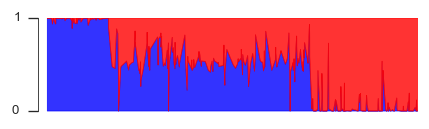

In [32]:
fig, ax = plt.subplots(figsize=(4, 1))
plot_parental_allele_balance(ax, callsets['3d7_hb3'], 'C06/PG0069-C/ERR019055', chrom, start=start, stop=stop)

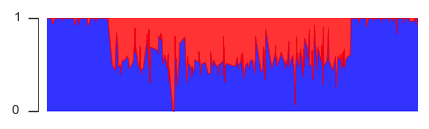

In [33]:
fig, ax = plt.subplots(figsize=(4, 1))
plot_parental_allele_balance(ax, callsets['3d7_hb3'], 'C05/PG0068-C/ERR019065', chrom, start=start, stop=stop)

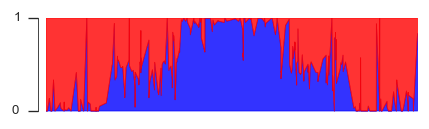

In [34]:
fig, ax = plt.subplots(figsize=(4, 1))
plot_parental_allele_balance(ax, callsets['hb3_dd2'], 'CH3_61/PG0033-Cx/ERR175544', chrom, start=start, stop=stop)

In [35]:
def plot_cnv_evidence_progeny(fig, cross, run, chrom, start, stop, label_axes=False, extra_label=''):
    
    gs = GridSpec(3, 1, height_ratios=[1, .6, .6])
    palette = sns.color_palette()
    
    ax = fig.add_subplot(gs[0])
    plot_cnv_state(ax, run, chrom, start=start, stop=stop)
    if label_axes:
        ax.text(0, 1, 'CN', fontsize=8, fontweight='bold', ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor='w', lw=0, alpha=1))
    ax.text(1, 1, '%s %s' % (run2clone[run], extra_label), 
            fontsize=8, fontweight='bold', 
            ha='right', va='top', 
            transform=ax.transAxes, 
            bbox=dict(facecolor='w', lw=0, alpha=1))
#     ax.set_ylabel('CN', fontsize=8, rotation=90, ha='right')
    
    ax = fig.add_subplot(gs[1])
    sns.despine(ax=ax, offset=5, bottom=True, left=False)
    plot_coverage_inversion(ax, run, chrom, start=start, stop=stop, color=palette[3], lw=1)
#     ax.set_ylabel(r'%DP', 
#                   rotation=90, ha='center', va='bottom', 
#                   color='k', fontweight='normal', fontsize=8)
#     ax.set_yticks([0, 10])
#     ax.set_yticklabels([0, 10], fontsize=8)
    ax.set_xticks([])
    ax.set_yticks([0, 40])
    ax.set_yticklabels(['0', '40'], fontsize=8)
    ax.set_ylim(0, 40)
    if label_axes:
        ax.text(0, .9, r'FA $\leftarrow$$\rightarrow$', color=palette[1], transform=ax.transAxes, ha='left', va='top',
                fontsize=8, fontweight='bold')
        ax.text(0, .6, r'SS $\rightarrow$$\rightarrow$', color=palette[3], transform=ax.transAxes, ha='left',va='top',
                fontsize=8, fontweight='bold')

    ax = ax.twinx()
    sns.despine(ax=ax, offset=5, bottom=True, right=True, left=True)
    plot_coverage_tandemdup(ax, run, chrom, start=start, stop=stop, color=palette[1], lw=1)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.set_ylim(0, 40)
#     ax.set_ylabel(r'%SS', 
#                   rotation=90, ha='center', va='top', 
#                   color=palette[3], fontweight='bold', fontsize=8)
    
    ax = fig.add_subplot(gs[2])
    sample = run2sample[run]
    plot_parental_allele_balance(ax, callsets[cross], sample, chrom, start=start, stop=stop)
    if label_axes:
        ax.text(-.08, .5, 'AB', ha='left', fontsize=8, fontweight='bold', va='center', transform=ax.transAxes)

    fig.tight_layout(h_pad=0)
    

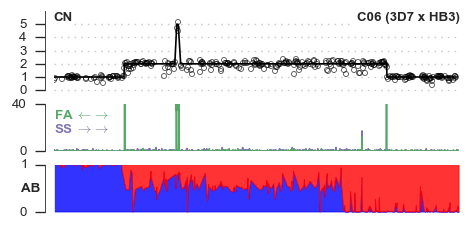

In [36]:
fig = plt.figure(figsize=(4, 2))
plot_cnv_evidence_progeny(fig, '3d7_hb3', 'ERR019055', chrom, start=start, stop=stop, 
                          extra_label='(3D7 x HB3)', label_axes=True)
fig.savefig('../../artwork/main/fig4G.jpg', dpi=900, jpeg_quality=100)

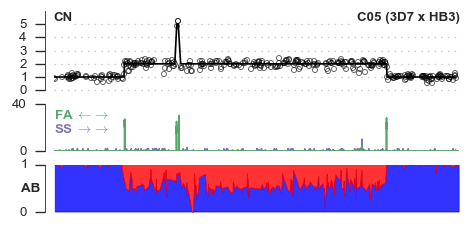

In [37]:
fig = plt.figure(figsize=(4, 2))
plot_cnv_evidence_progeny(fig, '3d7_hb3', 'ERR019065', chrom, start=start, stop=stop, extra_label='(3D7 x HB3)',
                         label_axes=True)
fig.savefig('../../artwork/main/fig4H.jpg', dpi=900, jpeg_quality=100)

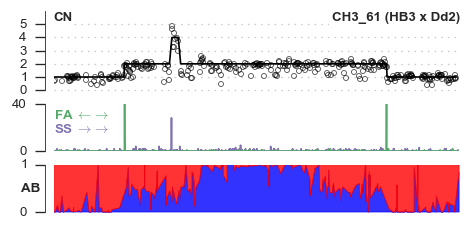

In [38]:
fig = plt.figure(figsize=(4, 2))
plot_cnv_evidence_progeny(fig, 'hb3_dd2', 'ERR175544', chrom, start=start, stop=stop, extra_label='(HB3 x Dd2)',
                          label_axes=True)
fig.savefig('../../artwork/main/fig4I.jpg', dpi=900, jpeg_quality=100)

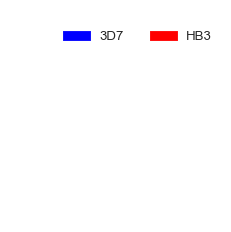

In [39]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(figsize=(2, 2))
ax.set_axis_off()
handles = []
handles.append(Patch(color='b', label='3D7'))
handles.append(Patch(color='r', label='HB3'))
ax.legend(handles=handles, ncol=2, loc='upper left', bbox_to_anchor=(0, 1), numpoints=1, fontsize=8, frameon=False, framealpha=.5);
fig.tight_layout()
fig.savefig('../../artwork/main/fig4G_legend.jpg', dpi=900, jpeg_quality=100)

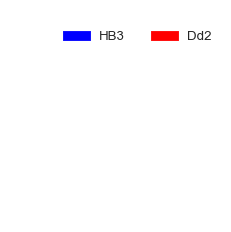

In [40]:
from matplotlib.patches import Patch
fig, ax = plt.subplots(figsize=(2, 2))
ax.set_axis_off()
handles = []
handles.append(Patch(color='b', label='HB3'))
handles.append(Patch(color='r', label='Dd2'))
ax.legend(handles=handles, ncol=2, loc='upper left', bbox_to_anchor=(0, 1), numpoints=1, fontsize=8, frameon=False, framealpha=.5);
fig.tight_layout()
fig.savefig('../../artwork/main/fig4I_legend.jpg', dpi=900, jpeg_quality=100)

## MDR1 for supplementary

In [28]:
chrom = 'Pf3D7_05_v3'
start, stop = 840000, 1020000

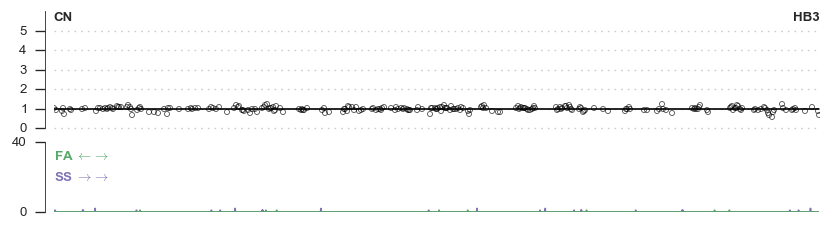

In [36]:
fig = plt.figure(figsize=(7, 2))
run = 'ERR012788'
plot_cnv_evidence(fig, run, chrom, start, stop, label_axes=True)
fig.savefig('../../artwork/supp/cnv_mdr1_{run}.jpg'.format(run=run), dpi=900, jpeg_quality=100)

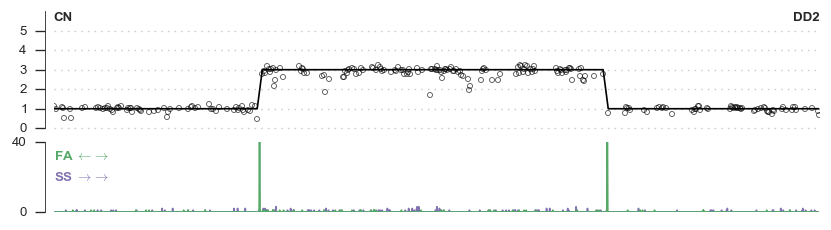

In [37]:
fig = plt.figure(figsize=(7, 2))
run = 'ERR012840'
plot_cnv_evidence(fig, run, chrom, start, stop, label_axes=True)
fig.savefig('../../artwork/supp/cnv_mdr1_{run}.jpg'.format(run=run), dpi=900, jpeg_quality=100)

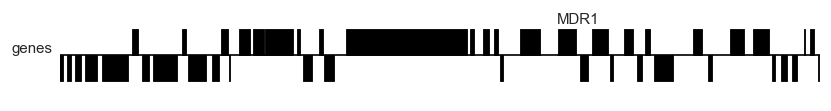

In [38]:
fig = plt.figure(figsize=(7, 1))
ax = fig.add_subplot(111)
annotate_genes = ['PF3D7_0523000']
gene_labels = {'PF3D7_0523000': 'MDR1'}
annotate_bbox = dict()
annotate_arrowprops = dict(arrowstyle='-',
                           connectionstyle='arc3',
                           shrinkA=0, shrinkB=0, linewidth=.5, edgecolor='k')
plot_genes(ax, chrom, start=start, stop=stop, annotate_genes=annotate_genes, gene_labels=gene_labels, annotate_xtext=0,
           annotate_ytext_fwd=19, annotate_bbox=annotate_bbox, annotate_arrowprops=annotate_arrowprops)
ax.spines['bottom'].set_visible(False)
ax.set_xticks([])
# ax.text(.9, -.7, 'chromosome 12\nposition (bp)', transform=ax.transAxes)
ax.set_ylabel('genes', rotation=0, ha='right');
fig.tight_layout()
fig.savefig('../../artwork/supp/cnv_mdr1_genes.jpg', dpi=900, jpeg_quality=100)